<a href="https://colab.research.google.com/github/dieguito1331/cienciaDatos/blob/master/UCEMA/04 - Revision - AutoML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install h2o --quiet
import numpy as np
import pandas as pd
np.random.seed(42)

import h2o
from h2o.automl import H2OAutoML
h2o.init(max_mem_size="2G")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.0/266.0 MB 1.6 MB/s eta 0:00:00
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "17.0.16" 2025-07-15; OpenJDK Runtime Environment (build 17.0.16+8-Ubuntu-0ubuntu122.04.1); OpenJDK 64-Bit Server VM (build 17.0.16+8-Ubuntu-0ubuntu122.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.12/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpo_0qtq50
  JVM stdout: /tmp/tmpo_0qtq50/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpo_0qtq50/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.8
H2O_cluster_version_age:,1 month and 5 days
H2O_cluster_name:,H2O_from_python_unknownUser_0c7g03
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.979 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [3]:



# --------------------------------------------------
# Generamos una base de clientes con variables simuladas
# --------------------------------------------------

n = 5000

# Variables explicativas
ingreso = np.random.normal(300000, 100000, n).clip(80000, 800000)       # pesos
score_crediticio = np.random.normal(600, 80, n).clip(300, 850)
antiguedad_laboral = np.random.exponential(5, n).clip(0, 30)             # años
edad = np.random.normal(40, 10, n).clip(21, 75)
monto_solicitado = np.random.normal(150000, 60000, n).clip(20000, 500000)
tasa = np.random.uniform(0.2, 0.8, n)
cant_prestamos_previos = np.random.poisson(2, n)

# --------------------------------------------------
# Generamos la probabilidad "real" de default
# --------------------------------------------------
# Supongamos: más ingreso y mayor score => menor default
# más tasa y más monto => más default
logit_true = (
    -3.0
    + 0.000004 * monto_solicitado
    + 2.0 * tasa
    - 0.005 * (score_crediticio - 600)
    - 0.000003 * ingreso
    + 0.03 * cant_prestamos_previos
)

# Calculamos probabilidad
p_default = 1 / (1 + np.exp(-logit_true))

# Generamos el default binario
default = np.random.binomial(1, p_default)

# Revisamos la proporción
print("Porcentaje de default simulado:", round(default.mean()*100, 2), "%")

# --------------------------------------------------
# Creamos el DataFrame final
# --------------------------------------------------
df = pd.DataFrame({
    "default": default,
    "ingreso": ingreso,
    "score_crediticio": score_crediticio,
    "monto_solicitado": monto_solicitado,
    "tasa": tasa,
    "cant_prestamos_previos": cant_prestamos_previos,
    "antiguedad_laboral": antiguedad_laboral,
    "edad": edad
})

df.head()

Porcentaje de default simulado: 11.52 %


,default,ingreso,score_crediticio,monto_solicitado,tasa,cant_prestamos_previos,antiguedad_laboral,edad
0,1,349671.415301,566.099225,109358.266277,0.535247,0,1.937550,67.359602
1,0,286173.569883,563.726871,162561.259811,0.753966,0,0.543604,45.687697
2,0,364768.853810,456.348546,117036.996963,0.506345,2,0.372581,33.701138
3,0,452302.985641,573.592785,105629.365722,0.375553,1,0.495103,43.479161
4,0,276584.662528,658.626327,109201.998304,0.413266,0,4.371779,57.806386


In [4]:
data = h2o.H2OFrame(df)
y = "default"
x = [c for c in data.columns if c != y]
data[y] = data[y].asfactor()  # H2O usa factores para clasificación

train, test = data.split_frame(ratios=[0.8], seed=42)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [5]:
# Ejecuta AutoML durante 60 segundos (ajustable)
aml = H2OAutoML(max_runtime_secs=60, seed=42, balance_classes=True)
aml.train(x=x, y=y, training_frame=train)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_1_AutoML_1_20251113_205323


GLM Model: summary
    family    link    regularization               lambda_search                                                                   number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  ------  ---------------------------  ------------------------------------------------------------------------------  ----------------------------  -----------------------------  ----------------------  -----------------------------------------------
    binomial  logit   Ridge ( lambda = 0.004067 )  nlambda = 30, lambda.max = 5.1611, lambda.min = 0.004067, lambda.1se = 0.04403  7                             7                              30                      AutoML_1_20251113_205323_training_py_3_sid_ba90

ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.09778785949734634
RMSE: 0.31271050429646
LogLoss: 0.33710739919534405
AUC: 0.6818721249930723
AUCPR: 0.22770619447586474
Gini: 0.3637442499861445
Null degrees of freedom: 4014
Residual degrees of freedom: 4007
Null deviance: 2890.9636806952994
Residual deviance: 2706.972415538613
AIC: 2722.972415538613

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.16903343889222028
       0     1    Error    Rate
-----  ----  ---  -------  --------------
0      2990  557  0.157    (557.0/3547.0)
1      283   185  0.6047   (283.0/468.0)
Total  3273  742  0.2092   (840.0/4015.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.169033     0.305785  156
max f2                       0.0884555    0.441073  282
max f0point5                 0.199073     0.286922  121
max accuracy                 0.513238     0.883188  0
max precision                0.35103      0.45      27
max recall                   0.0337809    1         377
max specificity              0.513238     0.999718  0
max absolute_mcc             0.169033     0.196988  156
max min_per_class_accuracy   0.116773     0.622216  232
max mean_per_class_accuracy  0.142863     0.630507  193
max tns                      0.513238     3546      0
max fns                      0.513238     468       0
max fps                      0.0117721    3547      399
max tps                      0.0337809    468       377
max tnr                      0.513238     0.999718  0
max fnr                      0.513238     1         0
max fpr                      0.0117721    1         399
max tpr                      0.0337809    1         377

Gains/Lift Table: Avg response rate: 11.66 %, avg score: 11.66 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0102117                   0.349457           3.76642   3.76642            0.439024         0.397186   0.439024                    0.397186            0.0384615       0.0384615                  276.642   276.642            0.0319772
2        0.0201743                   0.312584           2.57372   3.17743            0.3              0.327396   0.37037                     0.362722            0.025641        0.0641026                  157.372   217.743            0.0497242
3        0.030137                    0.290503           3.00267   3.11966            0.35             0.299559   0.363636                    0.341842            0.0299145       0.0940171                  200.267  

In [6]:
# Leaderboard con los mejores modelos
lb = aml.leaderboard
lb.head(rows=10)

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
GLM_1_AutoML_1_20251113_205323,0.676072,0.338793,0.220969,0.37922,0.313332,0.0981767
StackedEnsemble_BestOfFamily_3_AutoML_1_20251113_205323,0.675595,0.339126,0.219577,0.384273,0.313477,0.0982679
StackedEnsemble_BestOfFamily_2_AutoML_1_20251113_205323,0.674714,0.339359,0.219595,0.384132,0.31352,0.0982949
StackedEnsemble_AllModels_1_AutoML_1_20251113_205323,0.674402,0.339417,0.218685,0.374175,0.313564,0.0983221
StackedEnsemble_AllModels_2_AutoML_1_20251113_205323,0.673748,0.339829,0.216844,0.384087,0.313763,0.098447
StackedEnsemble_BestOfFamily_1_AutoML_1_20251113_205323,0.671507,0.339999,0.216835,0.369641,0.313819,0.0984825
GBM_1_AutoML_1_20251113_205323,0.626839,0.35226,0.179,0.412421,0.317966,0.101103
DeepLearning_1_AutoML_1_20251113_205323,0.62533,0.358138,0.175299,0.395779,0.321734,0.103513
XGBoost_3_AutoML_1_20251113_205323,0.624832,0.591433,0.166458,0.403502,0.451217,0.203596
GBM_5_AutoML_1_20251113_205323,0.619693,0.352394,0.17215,0.41009,0.318456,0.101414


In [7]:
leader = aml.leader
perf = leader.model_performance(test)
print(perf.auc())
print(perf.confusion_matrix())

0.6840238185734195
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1369298211687792
       0    1    Error    Rate
-----  ---  ---  -------  -------------
0      659  218  0.2486   (218.0/877.0)
1      52   56   0.4815   (52.0/108.0)
Total  711  274  0.2741   (270.0/985.0)


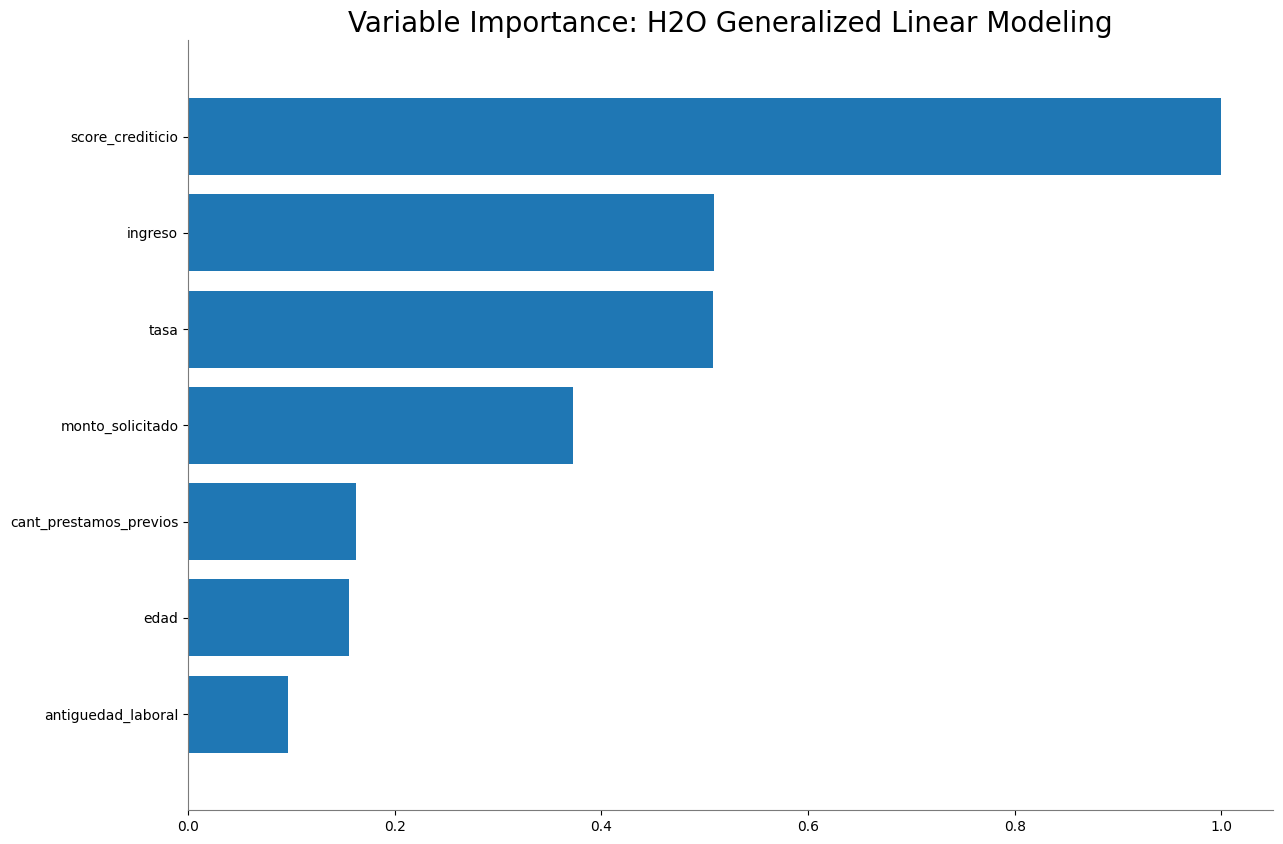

<Figure size 640x480 with 0 Axes>

In [8]:
leader.varimp_plot()

In [9]:
model_path = h2o.save_model(model=leader, path="./", force=True)
print("Modelo guardado en:", model_path)

Modelo guardado en: /content/GLM_1_AutoML_1_20251113_205323


In [17]:
leader = aml.leader
pred = leader.predict(test)
pred_df = pred.as_data_frame()
pred_default = pred_df["p1"]
test_df = test.as_data_frame()
test_df["prob_default"] = pred_default
# Ordenar de mayor a menor probabilidad de default
test_df = test_df.sort_values("prob_default", ascending=False).copy()

# Crear deciles (10 = mayor riesgo)
test_df["decil"] = pd.qcut(test_df["prob_default"], 10, labels=False) + 1

# Agrupar
table = test_df.groupby("decil").agg(
    defaults=("default", "sum"),
    no_defaults=("default", lambda x: (x == 0).sum()),
    total=("default", "count")
).reset_index()

# Ordenar de mayor a menor probabilidad de default
test_df = test_df.sort_values("prob_default", ascending=False).copy()

# Crear deciles (10 = mayor riesgo)
test_df["decil"] = pd.qcut(test_df["prob_default"], 10, labels=False) + 1

# Agrupar por decil
table = test_df.groupby("decil").agg(
    defaults=("default", "sum"),
    no_defaults=("default", lambda x: (x == 0).sum()),
    total=("default", "count")
).reset_index()

# Ordenar deciles de 10 → 1 (alto → bajo riesgo)
table = table.sort_values("decil", ascending=False).reset_index(drop=True)

# Acumulados brutos
table["defaults_acum"] = table["defaults"].cumsum()
table["no_defaults_acum"] = table["no_defaults"].cumsum()
table["total_acum"] = table["total"].cumsum()

# Totales
total_defaults = table["defaults"].sum()
total_no_defaults = table["no_defaults"].sum()

# Porcentajes por decil
table["pct_defaults_sobre_decil"] = table["defaults"] / table["total"]
table["pct_no_defaults_sobre_decil"] = table["no_defaults"] / table["total"]

# Porcentaje del decil sobre todos los defaults
table["pct_defaults_sobre_total_defaults"] = table["defaults"] / total_defaults

# 🔥 ACUMULADO del pct_defaults_sobre_total_defaults
table["pct_defaults_sobre_total_defaults_acum"] = table["pct_defaults_sobre_total_defaults"].cumsum()

# Porcentajes acumulados sobre el total de la base
table["pct_defaults_acum"] = table["defaults_acum"] / total_defaults
table["pct_no_defaults_acum"] = table["no_defaults_acum"] / total_no_defaults

# Reordenar columnas
table = table[[
    "decil",
    "defaults", "no_defaults", "total",
    "defaults_acum", "no_defaults_acum", "total_acum",
    "pct_defaults_acum"
]]

table


glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.12/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/usr/local/lib/python3.12/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


,decil,defaults,no_defaults,total,defaults_acum,no_defaults_acum,total_acum,pct_defaults_acum
0,10,21,78,99,21,78,99,0.194444
1,9,21,77,98,42,155,197,0.388889
2,8,15,84,99,57,239,296,0.527778
3,7,12,86,98,69,325,394,0.638889
4,6,10,88,98,79,413,492,0.731481
5,5,9,90,99,88,503,591,0.814815
6,4,8,90,98,96,593,689,0.888889
7,3,7,92,99,103,685,788,0.953704
8,2,3,95,98,106,780,886,0.981481
9,1,2,97,99,108,877,985,1.000000


In [11]:
test

default,ingreso,score_crediticio,monto_solicitado,tasa,cant_prestamos_previos,antiguedad_laboral,edad
0,253658,727.866,217591,0.667153,1,6.84162,55.5335
0,127508,606.129,129188,0.442888,3,2.53296,44.1746
0,306753,585.126,241810,0.426193,1,4.47667,37.4563
0,157525,472.048,236141,0.263971,2,6.6225,47.3684
0,485228,700.347,199753,0.515562,1,0.736501,42.3152
0,298650,658.48,181234,0.482358,6,3.34951,53.1505
0,228016,685.686,87717.1,0.69429,2,3.99732,25.9414
0,253936,434.041,130313,0.325524,1,0.65103,37.021
1,261492,628.093,144555,0.614408,1,0.301038,41.0715
1,403100,502.674,129709,0.701516,2,11.7038,62.3543
